In [1]:
%matplotlib inline
import nightscout
from pyloopkit import GlucoseStore, CarbStore, DoseStore, DoseEntryType, insulin_math, carb_math, date_math
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
from sklearn import linear_model
from dateutil import tz

local_timezone = tz.tzlocal()

In [2]:
api = nightscout.Api('https://mynssite.herokuapp.com')

duration = timedelta(days=14)
parameter_window_duration = timedelta(hours=6)
timestep_duration = timedelta(minutes=5)

analysis_end_date = date_math.date_floored_to_time_interval(datetime.now(pytz.utc), timestep_duration)
analysis_start_date = analysis_end_date - duration

In [3]:
timestep_count = int(parameter_window_duration.total_seconds() / timestep_duration.total_seconds())

In [4]:
# Insulin delivery
dose_store = DoseStore(api)
doses = list(dose_store.get_normalized_dose_entries(analysis_start_date, analysis_end_date))

In [5]:
# Carbs
carb_store = CarbStore(api)
carb_entries = carb_store.get_carb_entries(analysis_start_date, analysis_end_date)\

In [6]:
predition_start_date = analysis_start_date + parameter_window_duration

glucose_store = GlucoseStore(api)
glucose_values = glucose_store.get_glucose_values(predition_start_date, analysis_end_date)

insulin_rows = []
carb_rows = []
bg_change_rows = []
timestamps = []

bg_offset = 1
bg_delta_duration = timedelta(minutes=5) * bg_offset

for a, b in zip(glucose_values, glucose_values[bg_offset:]):
    
    if abs(((b.start_date - a.start_date) - bg_delta_duration).total_seconds()) > 10:
        print (b.start_date - a.start_date)
        continue
    
    # dependent var
    bg_change_rows.append(b.quantity - a.quantity)
    
    timestamps.append(a.start_date)
        
    # input variables = insulin & carbs over recent time period at fixed interval
    insulin = insulin_math.interpolate_doses_to_timeline(doses, a.start_date - parameter_window_duration, a.start_date, delta=timestep_duration)
    carbs = carb_math.interpolate_entries_to_timeline(carb_entries, a.start_date - parameter_window_duration, a.start_date, delta=timestep_duration)
    
    insulin_rows.append([i.value for i in insulin])
    carb_rows.append([c.quantity for c in carbs])



0:10:00
0:10:01
0:14:59
0:10:01
0:10:00
0:10:00
0:10:00
0:09:59
0:09:59
0:24:59
0:15:00
0:10:00
0:10:01
0:10:01
0:15:01
7:28:17
0:15:01
0:15:00
0:50:01
0:10:00
0:10:00
0:09:59
0:09:59


In [7]:
data = pd.concat([
    pd.DataFrame(insulin_rows).add_prefix('i'), 
    pd.DataFrame(carb_rows).add_prefix('c'), 
    pd.DataFrame(bg_change_rows, columns=["target"])], axis=1)

data.index = np.array(timestamps)
data.to_csv('insulin_carbs_bg.csv')
pd.DataFrame(carb_rows).add_prefix('c').to_csv('carbs.csv')
data[160:200]

,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,...,c63,c64,c65,c66,c67,c68,c69,c70,c71,target
2018-10-30 22:24:31+00:00,0.040569,0.087000,0.120521,0.109792,0.091646,0.057826,0.079931,0.145903,0.180222,3.849583,...,0,0,0,0,0,0,0,0,0,-8
2018-10-30 22:29:31+00:00,0.087000,0.120521,0.109792,0.091646,0.057826,0.079931,0.145903,0.180222,3.849583,0.145833,...,0,0,0,0,0,0,0,0,0,21
2018-10-30 22:34:31+00:00,0.120521,0.109792,0.091646,0.057826,0.079931,0.145903,0.180222,3.849583,0.145833,-0.058125,...,0,0,0,0,0,0,0,0,0,6
2018-10-30 22:39:31+00:00,0.109792,0.091646,0.057826,0.079931,0.145903,0.180222,3.849583,0.145833,-0.058125,-0.013333,...,0,0,0,0,0,0,0,0,0,1
2018-10-30 22:44:31+00:00,0.091646,0.057826,0.079931,0.145903,0.180222,3.849583,0.145833,-0.058125,-0.013333,0.000000,...,0,0,0,0,0,0,0,0,0,9
2018-10-30 22:49:31+00:00,0.057826,0.079931,0.145903,0.180222,3.849583,0.145833,-0.058125,-0.013333,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,13
2018-10-30 22:54:31+00:00,0.079931,0.145903,0.180222,3.849583,0.145833,-0.058125,-0.013333,0.000000,0.000000,0.023000,...,0,0,0,0,0,0,0,0,0,12
2018-10-30 22:59:31+00:00,0.145903,0.180222,3.849583,0.145833,-0.058125,-0.013333,0.000000,0.000000,0.023000,0.033333,...,0,0,0,0,0,0,0,0,0,12
2018-10-30 23:04:31+00:00,0.180222,3.849583,0.145833,-0.058125,-0.013333,0.000000,0.000000,0.023000,0.033333,0.003333,...,0,0,0,0,0,0,0,0,0,3
2018-10-30 23:09:31+00:00,3.849583,0.145833,-0.058125,-0.013333,0.000000,0.000000,0.023000,0.033333,0.003333,0.000000,...,0,0,0,0,0,0,0,0,0,9


In [8]:
# Filter out extreme values
data = data[(data.target > -30) & (data.target < 30)]

In [9]:
data_shuffled = data.sample(frac=1)
input = data_shuffled.iloc[:,:144]
target = data_shuffled.iloc[:,144]
print(input.shape)
print(target.shape)

(3793, 144)
(3793,)


In [10]:
n_training = int(len(input) * 0.8) # 80% training
n_testing = len(input) - n_training 

In [11]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(input[:n_training], target[:n_training])
reg.score(input[n_training:], target[n_training:])

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


-0.006314392764124488

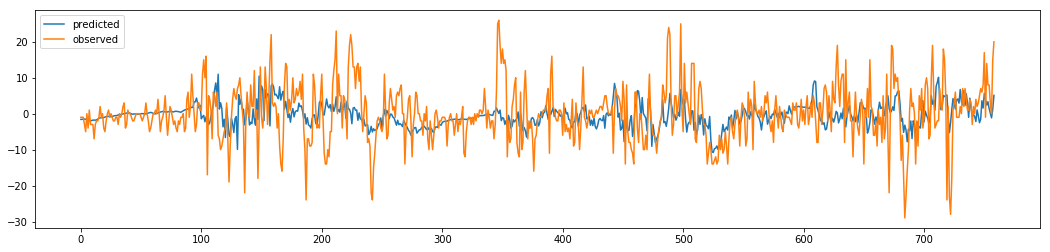

In [12]:
plt.figure(figsize=(18,4))
input = data.iloc[:,:144]
target = data.iloc[:,144]
p = reg.predict(input[n_training:])
plt.plot(p,label="predicted")
plt.plot(target[n_training:].tolist(),label="observed")
plt.legend(loc='upper left')


-49.24851753128221


<Container object of 72 artists>

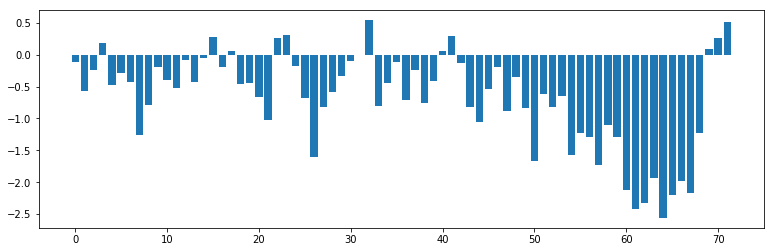

In [13]:
plt.figure(figsize=(13,4))
print(reg.coef_[:timestep_count].sum())
plt.bar(range(timestep_count),reg.coef_[:timestep_count])

4.320144061365749


<Container object of 72 artists>

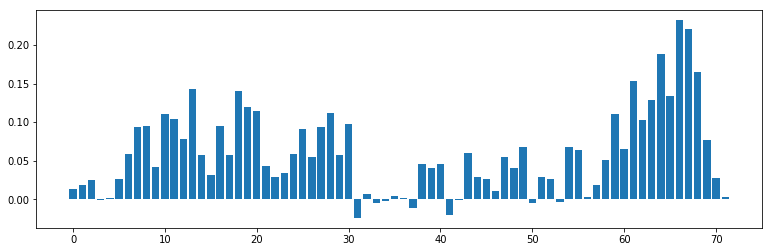

In [14]:
plt.figure(figsize=(13,4))
print(reg.coef_[timestep_count:].sum())
plt.bar(range(timestep_count), reg.coef_[timestep_count:])